# Comparing performance between ConvNet and Feed Forward Neural Networks on CIFAR-10

Artur Magalhaes Rodrigues dos Santos
NUSP 10297734

## Glossary
- [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html): dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 
- NN: short for Neural Network
- ConvNet: Convolutional Neural Network

## Summary

In this notebook, we investigate how NNs and ConvNets compare in predicting CIFAR-10.

## Goals

The goals are:
- understand how NNs may be used for vision tasks
- how convolutions help improve performance

The idea is to show that even though Neural Networks may have more parameters, depth and width than a Convolutional Neural Network, ConvNets have superior performance on most vision tasks, such as the one described in this notebook. We are not aiming for a great performance, but to show that ConvNets have higher accuracy than a "similar" Neural Network in the same problem.

Here we are trying to predict one of the 10 classes present on CIFAR-10.


## Code

In [119]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.utils import make_grid

### Auxiliary functions & hyperparameters

In [120]:
CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
LABELS_MAP = {i: label for i, label in enumerate(CLASSES)}

BATCH_SIZE = 4
EPOCHS = 50
HOME_PATH = '/home/tuts/data/cifar10'


def train(model: nn.Module, 
          criterion: torch.nn.modules.loss._Loss, 
          optimizer: torch.optim.Optimizer, 
          trainloader: DataLoader, 
          epochs=EPOCHS) -> None:
    """Trains model using criterion and optimizer. Data is loaded from trainloader

    Args:
        model (nn.Module): neural network model
        criterion (torch.nn.modules.loss._Loss): model loss component
        optimizer (torch.optim.Optimizer): optimizer
        trainloader (DataLoader): dataloader to train the model
        epochs (int, optional): number of epochs to train the model. Defaults to 20.
    """    
    model.train()
    for e in range(1, epochs+1):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()   
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            if i % 5000 == 0:
                print(f'[Epoch={e+1}, Iteration={i+1}] train loss: {loss.item():.3f}')


def count_parameters(model: nn.Module) -> int:
    """Counts number of trainable parameters in model

    Args:
        model (nn.Module): neural network model

    Returns:
        int: number of trainable parameters in model
    """    
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_performance_metrics(model: nn.Module, testloader: DataLoader) -> float:
    """Calculates model accuracy according to test data

    Args:
        model (nn.Module): neural network model
        testloader (DataLoader): dataloader to load test data

    Returns:
        float: accuracy
    """    
    with torch.no_grad():
        correct = 0
        total = 0
        model.eval()
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def plot_image(dataset, rows=3, cols=3) -> None:
    figure = plt.figure(figsize=(4, 4))
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        npimg = img.numpy()
        figure.add_subplot(rows, cols, i)
        plt.title(LABELS_MAP[label])
        plt.axis("off")
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_convolutional_layer(tensor: torch.Tensor, 
                                  ch: int=0, 
                                  allkernels: bool=False, 
                                  nrow=8, 
                                  padding=1) -> None: 
    """Creates visualization for convolutional layers. It displays images from the tensor

    Args:
        tensor (torch.Tensor): Tensor from convolutional layer.
        ch (int, optional): Number of channels. Defaults to 0.
        allkernels (bool, optional): Flag to visualize all kernels. Defaults to False.
        nrow (int, optional): Number of rows. Defaults to 8.
        padding (int, optional): Padding. Defaults to 1.
    """    
    n,c,h,w = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


Now we are going to load CIFAR-10.

Here, we are using `CIFAR10` and `DataLoader` from `torch.utils.data`.

We apply 3 transformations to both sets:
- transform to Tensor
- also to Grayscale
- normalize images

In [121]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

trainset = CIFAR10(root=HOME_PATH, train=True,
                   download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=2)

testset = CIFAR10(root=HOME_PATH, train=False,
                  download=True, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


The dataset is composed of images on 32x32 format.

They have all 10 labels attached to the images.

In [122]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

images.shape

torch.Size([4, 1, 32, 32])

Here's an example of what the dataset contains.

Notice that images were transformed to grayscale.

Training set = 50000
Test set = 10000


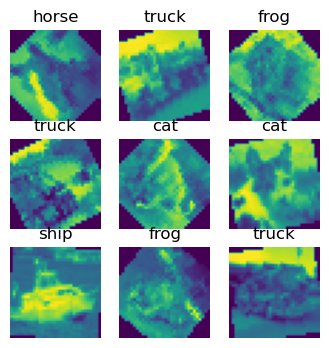

In [123]:
print(f'Training set = {len(trainset)}')
print(f'Test set = {len(testset)}')

plot_image(trainset)

Let's define the neural networks we are going to use for our experiments:

- one simpler NN: containing Liner layers with ReLU activation
- deeper NN: same number as layers as ConvNet but only Linear
- one ConvNet
- one ConvNet with more channels in the first layer

In [124]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class NetDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 528)
        self.fc3 = nn.Linear(528, 120)
        self.fc4 = nn.Linear(120, 84)
        self.fc5 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ConvNetWithChannels(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 24, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(24, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We are now going to train the Convolutional and Neural Network.

Verify that the ConvNet has 46% less parameters than Net:

In [125]:
convnet = ConvNet()
net = Net()
print(f'Number of trainable parameters for Feed Forward: {count_parameters(net)}')
print(f'Number of trainable parameters for ConvNet: {count_parameters(convnet)}')

optimizer = optim.AdamW(convnet.parameters())
criterion = nn.CrossEntropyLoss()

optimizer_nn = optim.AdamW(net.parameters())
criterion_nn = nn.CrossEntropyLoss()

print(f'Training ConvNet...')
train(convnet, criterion, optimizer, trainloader, epochs=10)
print(f'Training Feed Forward...')
train(net, criterion_nn, optimizer_nn, trainloader, epochs=10)

Number of trainable parameters for Feed Forward: 134014
Number of trainable parameters for ConvNet: 61706
Training ConvNet...
[Epoch=2, Iteration=1] loss: 2.324
[Epoch=2, Iteration=5001] loss: 1.392
[Epoch=2, Iteration=10001] loss: 1.845
[Epoch=3, Iteration=1] loss: 2.641
[Epoch=3, Iteration=5001] loss: 1.581
[Epoch=3, Iteration=10001] loss: 2.193
[Epoch=4, Iteration=1] loss: 1.349
[Epoch=4, Iteration=5001] loss: 1.553
[Epoch=4, Iteration=10001] loss: 0.799
[Epoch=5, Iteration=1] loss: 1.455
[Epoch=5, Iteration=5001] loss: 1.562
[Epoch=5, Iteration=10001] loss: 0.951
[Epoch=6, Iteration=1] loss: 2.305
[Epoch=6, Iteration=5001] loss: 1.370
[Epoch=6, Iteration=10001] loss: 1.171
[Epoch=7, Iteration=1] loss: 1.014
[Epoch=7, Iteration=5001] loss: 1.854
[Epoch=7, Iteration=10001] loss: 1.113
[Epoch=8, Iteration=1] loss: 1.590
[Epoch=8, Iteration=5001] loss: 0.772
[Epoch=8, Iteration=10001] loss: 1.769
[Epoch=9, Iteration=1] loss: 1.418
[Epoch=9, Iteration=5001] loss: 1.807
[Epoch=9, Iterati

We do the same for some variations of our previous architecture:
- one deeper ConvNet
- one ConvNet with more channels in the first layer

In [126]:
convnetchannels = ConvNetWithChannels()
deepnet = NetDeep()
print(f'Number of trainable parameters for NetDeep: {count_parameters(deepnet)}')
print(f'Number of trainable parameters for ConvNetWithMoreChannels: {count_parameters(convnetchannels)}')

optimizercnwc = optim.AdamW(convnetchannels.parameters())
criterioncnwc = nn.CrossEntropyLoss()

optimizerdnn = optim.AdamW(deepnet.parameters())
criteriondnn = nn.CrossEntropyLoss()

print(f'Training ConvNetWithMoreChannels...')
train(convnetchannels, criterioncnwc, optimizercnwc, trainloader, epochs=10)
print(f'Training NetDeep...')
train(deepnet, criteriondnn, optimizerdnn, trainloader, epochs=10)

Number of trainable parameters for NetDeep: 1665294
Number of trainable parameters for ConvNetWithMoreChannels: 69374
Training ConvNetWithMoreChannels...


[Epoch=2, Iteration=1] loss: 2.298
[Epoch=2, Iteration=5001] loss: 2.473
[Epoch=2, Iteration=10001] loss: 2.072
[Epoch=3, Iteration=1] loss: 1.661
[Epoch=3, Iteration=5001] loss: 1.245
[Epoch=3, Iteration=10001] loss: 1.249
[Epoch=4, Iteration=1] loss: 0.888
[Epoch=4, Iteration=5001] loss: 1.625
[Epoch=4, Iteration=10001] loss: 1.166
[Epoch=5, Iteration=1] loss: 1.790
[Epoch=5, Iteration=5001] loss: 0.768
[Epoch=5, Iteration=10001] loss: 1.135
[Epoch=6, Iteration=1] loss: 0.616
[Epoch=6, Iteration=5001] loss: 1.451
[Epoch=6, Iteration=10001] loss: 1.203
[Epoch=7, Iteration=1] loss: 2.260
[Epoch=7, Iteration=5001] loss: 0.575
[Epoch=7, Iteration=10001] loss: 0.842
[Epoch=8, Iteration=1] loss: 0.568
[Epoch=8, Iteration=5001] loss: 1.144
[Epoch=8, Iteration=10001] loss: 0.948
[Epoch=9, Iteration=1] loss: 0.683
[Epoch=9, Iteration=5001] loss: 1.344
[Epoch=9, Iteration=10001] loss: 1.631
[Epoch=10, Iteration=1] loss: 1.791
[Epoch=10, Iteration=5001] loss: 1.227
[Epoch=10, Iteration=10001] l

Torch enables us to save the models, making them reusable, so we just load up them later:

In [127]:
torch.save(net.state_dict(), f'{HOME_PATH}/cifar_net.pth')
torch.save(convnet.state_dict(), f'{HOME_PATH}/cifar_convnet.pth')

torch.save(deepnet.state_dict(), f'{HOME_PATH}/cifar_deepnet.pth')
torch.save(convnetchannels.state_dict(), f'{HOME_PATH}/cifar_convnetchannels.pth')

Convolutional Neural Networks, although understood as black box models, have one advantage over standard Neural Networks as we may visualize convolutional layers.

As convolutional layers consist of learned filters or kernels that extract specific features from the input data, we can visualize these filters to gain insights into what kind of patterns or features the network is learning to detect. This visualization can help us interpret and understand the intermediate representations within the network, aiding in model debugging, fine-tuning, and even providing a form of transparency in an otherwise complex and opaque deep learning model.

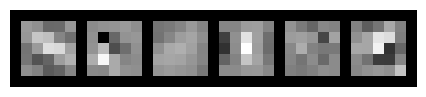

In [128]:
filter = convnet.conv1.weight.data.clone()
visualize_convolutional_layer(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

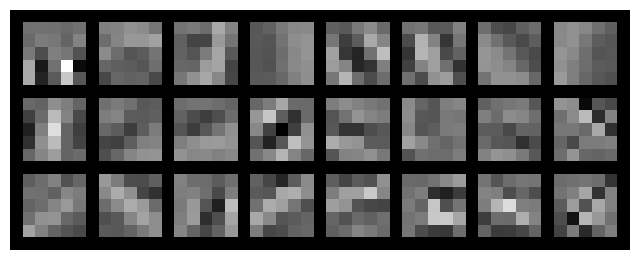

In [129]:
filter = convnetchannels.conv1.weight.data.clone()
visualize_convolutional_layer(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

In [130]:
print(f'Performance metrics (accuracy) for:\n- ConvNet = {calculate_performance_metrics(convnet, testloader)}\n- Feed Forward = {calculate_performance_metrics(net, testloader)}')


Performance metrics (accuracy) for:
- ConvNet = 0.5169
- Feed Forward = 0.3582


In [131]:
print(f'Performance metrics (accuracy) for:\n- ConvNet = {calculate_performance_metrics(convnetchannels, testloader)}\n- Feed Forward = {calculate_performance_metrics(deepnet, testloader)}')


Performance metrics (accuracy) for:
- ConvNet = 0.5121
- Feed Forward = 0.3685


So now, we empirically, by this small "test" verified that our trained ConvNets performed much better than our Feed Forward networks.

If you run this notebook, you may get different results for accuracy measures, but ConvNets will remain better than Feed Forward networks.

Possible improvements here could be:
- running more epochs
- trying different network architectures
- using RGB images
- verifying and stopping when validation loss increases during train loop


Hope this notebook helped you on understanding a bit better on how to construct, use and compare Convolutional Neural Networks.